In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [3]:

train_data = pd.read_csv('C:/Users/sajin/project/models/clean_data.csv')
train_data.columns

Index(['Unnamed: 0', 'ID', 'ProdID', 'Rating', 'ReviewCount', 'Category',
       'Brand', 'Name', 'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [4]:
train_data.shape

(4090, 11)

In [5]:
# Display the data types of each column
print(train_data.dtypes)


Unnamed: 0       int64
ID               int64
ProdID           int64
Rating         float64
ReviewCount    float64
Category        object
Brand           object
Name            object
ImageURL        object
Description     object
Tags            object
dtype: object


In [ ]:
# Convert the ReviewCount column to numeric
train_data['ReviewCount'] = pd.to_numeric(train_data['ReviewCount'], errors='coerce')

In [6]:
train_data.isnull().sum()

Unnamed: 0       0
ID               0
ProdID           0
Rating           0
ReviewCount      0
Category         9
Brand           96
Name             0
ImageURL         0
Description    916
Tags             0
dtype: int64

In [8]:
# Fill missing values
train_data['Category'].fillna('Unknown', inplace=True)
train_data['Brand'].fillna('Unknown', inplace=True)
train_data['Description'].fillna('No description available', inplace=True)


In [9]:
train_data.isnull().sum()


Unnamed: 0     0
ID             0
ProdID         0
Rating         0
ReviewCount    0
Category       0
Brand          0
Name           0
ImageURL       0
Description    0
Tags           0
dtype: int64

In [10]:
train_data.duplicated().sum()

np.int64(0)

In [11]:
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1666
Number of unique items: 1607
Number of unique ratings: 36


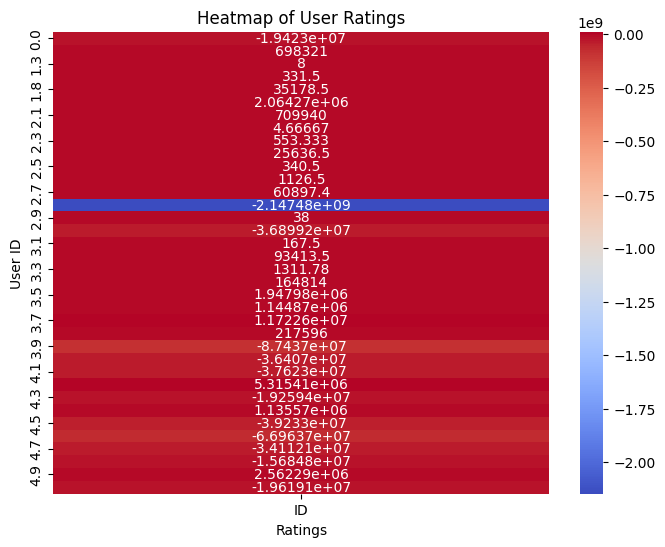

In [12]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

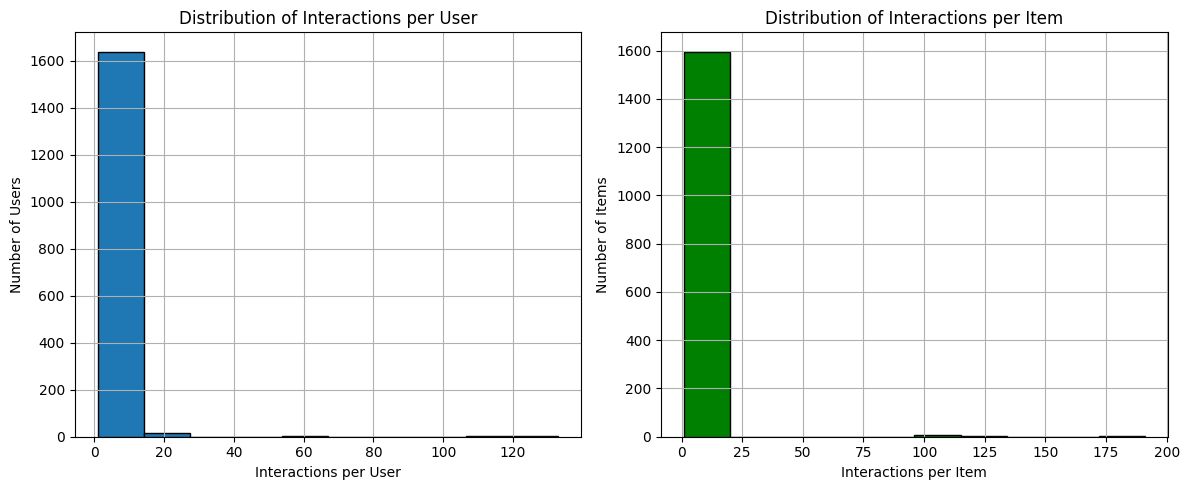

In [13]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

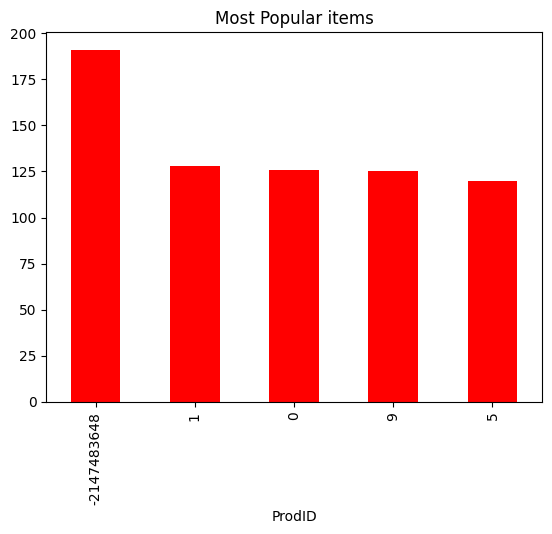

In [14]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

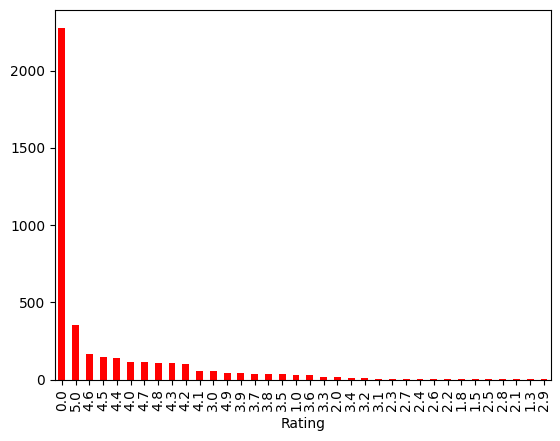

In [15]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

In [16]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

C:\Users\sajin\AppData\Roaming\Python\Python312\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [17]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [18]:

average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [19]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [20]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

C:\Users\sajin\AppData\Local\Temp\ipykernel_30044\565725879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
C:\Users\sajin\AppData\Local\Temp\ipykernel_30044\565725879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [21]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


C:\Users\sajin\AppData\Local\Temp\ipykernel_30044\393183274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5
14,($33 Value) Sol De Janeiro Carnaval Shimmer Gi...,2,"sol, de, janeiro",https://i5.walmartimages.com/asr/433fca9d-d5c2...,5
10,($206 Value) Peter Thomas Roth Face Mask Frenz...,1,"peter, thomas, roth",https://i5.walmartimages.com/asr/f5fae452-5c37...,5
9,($19 Value) Jack Black Pit Boss Antiperspirant...,3,"jack, black",https://i5.walmartimages.com/asr/d03b6f4e-27e3...,5
944,Chlorella Powder Broken Cell,1,"holistic, herbal, solutions",https://i5.walmartimages.com/asr/c8af353d-c591...,5
4014,"carmex lip balm stick, strawberry, 3 count",1,carmex,https://i5.walmartimages.com/asr/adbcfbe8-fb3c...,5
4001,"all Free Clear For Sensitive Skin, 110 Loads, ...",4,unknown,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5
62,(2 Packs) Crest 4 In 1 Fluoride Anticavity Too...,1,crest,https://i5.walmartimages.com/asr/44ea137f-ab6d...,5
58,(2 Pack) Spring Valley Apple Cider Vinegar Cap...,2,"spring, valley",https://i5.walmartimages.com/asr/7b4c7801-3747...,5
1575,"Gaiam Kids Yoga Mat Pink Zebra, 4mm",13,gaiam,https://i5.walmartimages.com/asr/1e3a766f-4185...,5


In [23]:
import pandas as pd

# Creating a dictionary with your data
data = {
    'Name': [
        'DermOrganic Intensive Hair Repair Masque 33.8 Oz',
        'Dermalogica Conditioning Body Wash Pro 32 oz (...)',
        'Dermalogica Sheer Tint Tinted Moisturizer SPF ...',
        'Design Essentials Natural Coconut & Monoi Curl...',
        'Design.Me Root Lift Volumizing Powder Puff Me ...',
        'Dax High & Tight Awesome Shine Hair Dress 3.5 oz',
        'Ddrops Booster Liquid Vitamin D3 600 IU 0 09 f...',
        'carmex lip balm stick, strawberry, 3 count',
        'Dl Permatex Blue Label 01406 Cream Hand Cleane...',
        'Dorothy Gray Satura Moisture Cream with Vitami...'
    ],
    'ReviewCount': [3, 1, 1, 1, 1, 1, 6, 1, 2, 1],
    'Brand': [
        'dermorganic', 'dermalogica', 'dermalogica', 
        'design, essentials', 'design', 'dax', 
        'ddrops', 'carmex', 'permtx, lockt', 
        'dorothy, gray'
    ],
    'ImageURL': [
        'https://i5.walmartimages.com/asr/3c14a936-2b0f...',
        'https://i5.walmartimages.com/asr/74486e21-a298...',
        'https://i5.walmartimages.com/asr/2099e2a7-64f5...',
        'https://i5.walmartimages.com/asr/ff2dba1d-0c02...',
        'https://i5.walmartimages.com/asr/ea1400a7-a4d5...',
        'https://i5.walmartimages.com/asr/9d94a3fc-58d0...',
        'https://i5.walmartimages.com/asr/2b397feb-bc62...',
        'https://i5.walmartimages.com/asr/adbcfbe8-fb3c...',
        'https://i5.walmartimages.com/asr/fdf5474d-f71f...',
        'https://i5.walmartimages.com/asr/e1e1ef79-385f...'
    ],
    'Rating': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Saving the DataFrame to a CSV file
df.to_csv('C:/Users/sajin/project/models/trending_products.csv', index=False)



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [25]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [26]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [27]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [28]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
155,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
183,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
203,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
234,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
318,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
366,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
392,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
671,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
820,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [30]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
155,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
183,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
203,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
234,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
318,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
366,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
392,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
671,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [31]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
2870,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
525,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
3371,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
3398,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1409,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2445,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3758,Be Matte Lipstick - Soft Pink,2.0,"city, color",https://i5.walmartimages.com/asr/69e1ec63-be5e...,3.0
1194,Be Matte Lipstick - Baby Pink,2.0,"city, color",https://i5.walmartimages.com/asr/acadf0c0-739f...,3.0
